# Modelo DNN

In [1]:
import time, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os, random
# MLP TABULAR EN KERAS (con grid manual y métricas)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
SEED = 42
# Carga dataset desde la carpeta raíz generada por TINTOlib
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

## Limpieza

In [ ]:
# Quitar valores de la CATEGORIA = 2
df_filtrado = df[df["CATEGORIA"] != 2].copy()

# Re-mapear las clases a valores consecutivos desde 0
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA","lon","lat","year"])


## Data de entrenamiento y prueba

In [ ]:
# 1) Split en train / val / test (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, stratify=y_train, random_state=42
)

# 2) Escalado con ajustes SOLO en train
scaler = StandardScaler()
X_tr  = scaler.fit_transform(X_tr).astype("float32")
X_val = scaler.transform(X_val).astype("float32")
X_test= scaler.transform(X_test).astype("float32")

num_features = X_tr.shape[1]
num_classes  = np.unique(y_tr).size

## Definir modelo entrenamiento

In [ ]:
def build_mlp(h1=64, h2=32, dropout=0.0, lr=1e-3, wd=0.0):
    inputs = keras.Input(shape=(num_features,))
    x = layers.Dense(h1, activation="relu", kernel_regularizer=keras.regularizers.l2(wd))(inputs)
    if dropout: x = layers.Dropout(dropout)(x)
    x = layers.Dense(h2, activation="relu", kernel_regularizer=keras.regularizers.l2(wd))(x)
    if dropout: x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )
    return model

early_stopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, restore_best_weights=True)


## Entrenamiento y testeo

MLP Grich 1: h1=64, h2=32, dropout=0.0, lr=0.001, wd=0.0


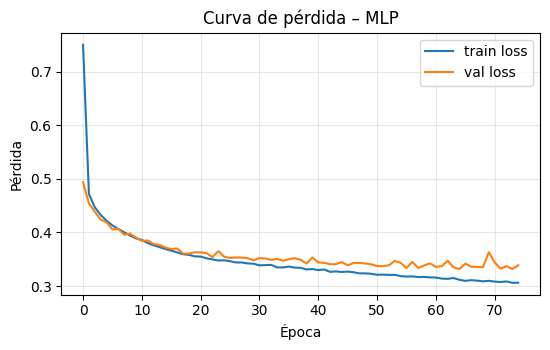

OA:0.8870 | Prec(macro):0.8446 | Recall(macro):0.8052 | F1-macro:0.8237 | val_loss:0.3387 | val_acc:0.8777
⏱ Train:18.70s | Test:0.108s (0.01 ms/muestra)


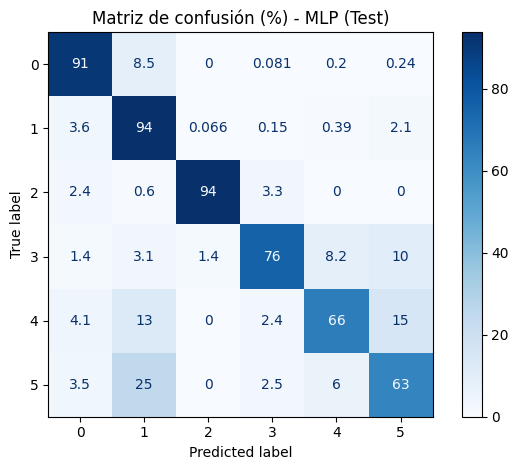

--------------------------------------------------------------------------------
MLP Grich 2: h1=64, h2=64, dropout=0.0, lr=0.001, wd=0.0


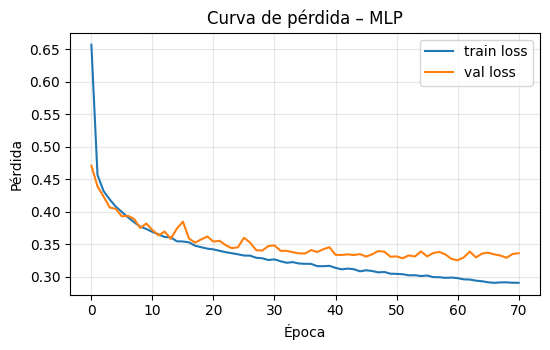

OA:0.8887 | Prec(macro):0.8429 | Recall(macro):0.8182 | F1-macro:0.8297 | val_loss:0.3361 | val_acc:0.8850
⏱ Train:17.72s | Test:0.108s (0.01 ms/muestra)


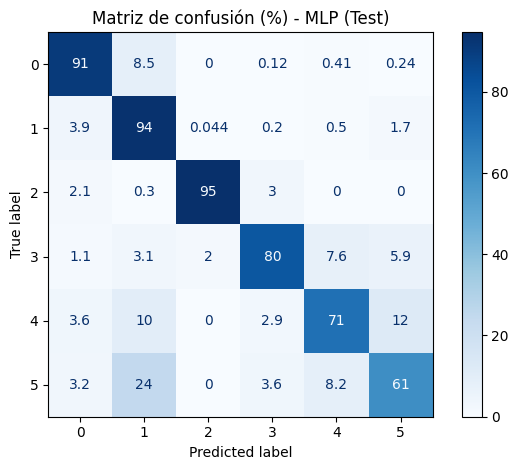

--------------------------------------------------------------------------------
MLP Grich 3: h1=128, h2=32, dropout=0.0, lr=0.001, wd=0.0


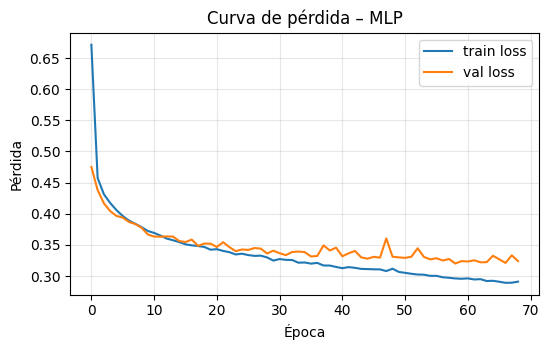

OA:0.8905 | Prec(macro):0.8473 | Recall(macro):0.8101 | F1-macro:0.8264 | val_loss:0.3241 | val_acc:0.8875
⏱ Train:17.64s | Test:0.109s (0.01 ms/muestra)


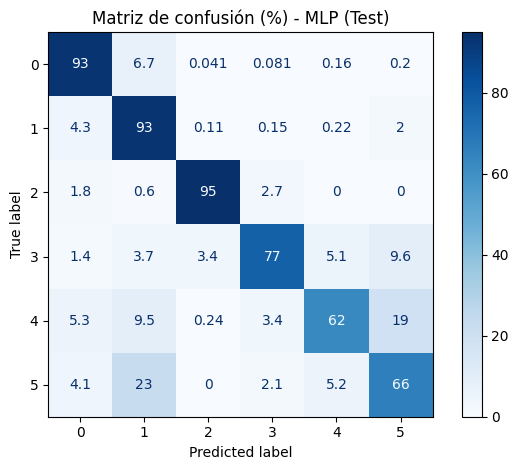

--------------------------------------------------------------------------------
MLP Grich 4: h1=128, h2=64, dropout=0.0, lr=0.001, wd=0.0


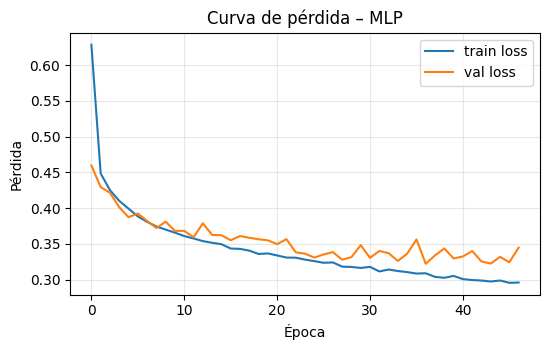

OA:0.8888 | Prec(macro):0.8466 | Recall(macro):0.8160 | F1-macro:0.8301 | val_loss:0.3449 | val_acc:0.8806
⏱ Train:12.32s | Test:0.107s (0.01 ms/muestra)


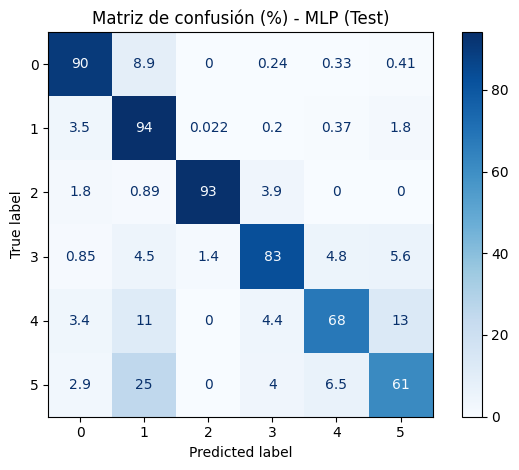

--------------------------------------------------------------------------------


In [33]:
import itertools

h1 = [64, 128]
h2 = [32, 64]
dropout = [0.0]
lr = [1e-3]
wd = [0.0] 

num = 0
for h1, h2, dropout, lr, wd in itertools.product(
        h1, h2, dropout, lr, wd):
    num = num + 1
    print(f"MLP Grich {num}: h1={h1}, h2={h2}, dropout={dropout}, lr={lr}, wd={wd}")
    
    # 3) Modelo
    #model = build_mlp(h1=64, h2=32, dropout=0.0, lr=1e-3, wd=0.0)
    model = build_mlp(h1=h1, h2=h2, dropout=dropout, lr=lr, wd=wd)
    EPOCH = 100

    # Early stopping por validación
    early_stopper = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True
    )

    # 4) Entrenamiento con validación (NO se toca test aquí)
    t0 = time.perf_counter()
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCH,
        batch_size=64,
        shuffle=True,
        verbose=0,
        callbacks=[early_stopper]
    )
    fit_s = time.perf_counter() - t0

    # 5) Curvas de pérdida (train y val)
    plt.figure(figsize=(5.6,3.6))
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.xlabel("Época"); plt.ylabel("Pérdida")
    plt.title("Curva de pérdida – MLP")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # 6) Evaluación FINAL en TEST (una sola vez)
    t0 = time.perf_counter()
    y_pred = model.predict(X_test, batch_size=128, verbose=0).argmax(axis=1)
    pred_s = time.perf_counter() - t0
    ms_per_sample = (pred_s/len(y_test))*1000

    oa = accuracy_score(y_test, y_pred)
    prec, rec, f1m, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    cm  = confusion_matrix(y_test, y_pred)
    cm_row_pct = np.nan_to_num(cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100)

    print(
    f"OA:{oa:.4f} | Prec(macro):{prec:.4f} | Recall(macro):{rec:.4f} | F1-macro:{f1m:.4f} | "
    f"val_loss:{history.history.get('val_loss', [-1])[-1]:.4f} | "
    f"val_acc:{history.history.get('val_accuracy', [-1])[-1]:.4f}"
          )
    print(f"⏱ Train:{fit_s:.2f}s | Test:{pred_s:.3f}s ({ms_per_sample:.2f} ms/muestra)")

    ConfusionMatrixDisplay(cm_row_pct).plot(cmap='Blues', colorbar=True)
    plt.title("Matriz de confusión (%) - MLP (Test)")
    plt.tight_layout(); plt.show()

    print("-"*80)


# Registrar informacion